In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import time
from itertools import combinations, product
import copy
import functools
import random

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
def get_distance_matrix(df):
    coords = df[['x', 'y']].to_numpy()
    
    distance_matrix = np.round(squareform(pdist(coords, 'euclidean')))
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix


def random_search(distance_matrix):
    n = len(distance_matrix)
    
    solution = list(range(n))
    np.random.shuffle(solution)
    
    return solution[:(n//2)]


def get_total_cost(solution, distance_matrix, costs):
    assert len(solution) * 2 == len(distance_matrix)
    total_cost = 0
    
    for i in range(len(solution)-1):
        total_cost += distance_matrix[solution[i], solution[i+1]] + costs[solution[i+1]]
        
    total_cost += distance_matrix[solution[-1], solution[0]] + costs[solution[0]]
        
    return total_cost


In [ ]:
def compute_inter_move_delta(solution, distance_matrix, costs, idx, new_node):
    n = len(solution)
    new_solution = solution.copy()
    old_node = solution[idx]

    new = (costs[new_node] +
            distance_matrix[new_solution[idx-1], new_node] +
            distance_matrix[new_node, new_solution[(idx+1)%n]])

    old = (costs[old_node] +
             distance_matrix[new_solution[idx-1], old_node] +
             distance_matrix[old_node, new_solution[(idx+1)%n]])

    delta = new - old
    new_solution[idx] = new_node

    return new_solution, delta



def compute_intra_move_delta(solution, distance_matrix, indices, backward=False):
    ## without roll/shift to initial form
    n = len(solution)
    i, j = indices
    
    if i >= j: raise Exception('Wrong indices, i >= j')
    if j >= n: raise Exception('Wrong indices, j >= n')
    
    if backward:
        if (i == 0 and j in (n-1, n-2)) or (j == n-1 and i in (0, 1)):
            return solution, 0
        new = distance_matrix[solution[i], solution[(j+1)%n]] + distance_matrix[solution[j], solution[i-1]]
        old = distance_matrix[solution[i-1], solution[i]] + distance_matrix[solution[j], solution[(j+1)%n]]
    else:
        if j - i in (1, 2):
            return solution, 0
        new = distance_matrix[solution[i], solution[j-1]] + distance_matrix[solution[i+1], solution[j]]
        old = distance_matrix[solution[i], solution[i+1]] + distance_matrix[solution[j-1], solution[j]]
        
    delta = new - old
    
    if backward:
        new_solution = solution[j+1:][::-1] + solution[i:j+1] + solution[:i][::-1]
    else:
        new_solution = solution[:i+1] + solution[i+1:j][::-1] + solution[j:]

    return new_solution, delta



def steepest_local_search(solution, distance_matrix, costs):
    solution = solution[:]
    n, N = len(solution), len(distance_matrix)
    solution_set = set(solution)
    outer_nodes_set = set(range(N)) - solution_set 
    
    while True:
        best_delta, best_solution = 0, None
        inter_move_flag, inter_move_outer_node, inter_move_inner_node_idx = False, None, None
        
        # inter
        for outer_node, inner_node_idx in product(outer_nodes_set, range(n)):
            new_solution, delta = compute_inter_move_delta(solution, distance_matrix, costs, inner_node_idx, outer_node)
            if delta < best_delta:
                best_delta = delta
                best_solution = new_solution[:]
                inter_move_flag = True
                inter_move_outer_node, inter_move_inner_node_idx = outer_node, inner_node_idx
                
        # intra
        for i, j in combinations(range(n), 2):
            # forward
            new_solution, delta = compute_intra_move_delta(solution, distance_matrix, (i, j), False)
            if delta < best_delta:
                best_delta = delta
                best_solution = new_solution[:]
                inter_move_flag = False
            # backward
            new_solution, delta = compute_intra_move_delta(solution, distance_matrix, (i, j), True)
            if delta < best_delta:
                best_delta = delta
                best_solution = new_solution[:]
                inter_move_flag = False
        
        if best_solution is not None:
            if inter_move_flag:
               solution_set.add(inter_move_outer_node) 
               solution_set.remove(solution[inter_move_inner_node_idx])
               outer_nodes_set.remove(inter_move_outer_node) 
               outer_nodes_set.add(solution[inter_move_inner_node_idx]) 
            solution = best_solution[:]             
            continue
        return solution

In [ ]:
def msls(instance, num_runs=200):
    df = pd.read_csv(f'../data/{instance}.csv', sep=';', names=['x', 'y', 'cost'])
    costs = df.cost.to_numpy()
    distance_matrix = get_distance_matrix(df)

    best_total_cost, best_solution = float('inf'), None
    for _ in range(num_runs):
        solution = random_search(distance_matrix)
        new_solution = steepest_local_search(solution, distance_matrix, costs)
        total_cost = get_total_cost(new_solution, distance_matrix, costs)
        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_solution = new_solution[:]
            
    return best_total_cost, best_solution

In [ ]:
def random_insertion(solution, n=5):
    for i in range(n):
        which, where = random.randint(0, len(solution)-1), random.randint(0, len(solution))
        solution.insert(where, solution.pop(which))
    return solution



def double_bridge_move(solution):
    a, b, c = sorted(random.sample(range(1, len(solution) - 2), 3))
    return solution[:a] + solution[c:] + solution[b:c] + solution[a:b]



def shuffle_sub_tour(solution):
    n = len(solution)
    sub_tour_length = random.randint(int(0.05 * n), int(0.15 * n))
    start_idx = random.randint(0, n - sub_tour_length)
    end_idx = start_idx + sub_tour_length

    sub_tour = solution[start_idx:end_idx]
    random.shuffle(sub_tour)
    solution = solution[:start_idx] + sub_tour + solution[end_idx:]

    return solution



def random_jump(solution):
    n = len(solution)
    sub_tour_length = random.randint(int(0.05 * n), int(0.15 * n))
    start_idx = random.randint(0, n - sub_tour_length)
    end_idx = start_idx + sub_tour_length
    sub_tour = solution[start_idx:end_idx]

    new_solution = solution[:start_idx] + solution[end_idx:]

    insert_idx = random.randint(0, len(new_solution))
    new_solution = new_solution[:insert_idx] + sub_tour + new_solution[insert_idx:]

    return new_solution



def k_opt_move(solution, k=4):
    n = len(solution)
    edges = sorted(random.sample(range(n), k))
    edges.append(edges[0])

    new_solution = []
    for i in range(k):
        start, end = edges[i], edges[i + 1]
        if start < end:
            new_solution.extend(solution[start:end])
        else:
            new_solution.extend(solution[start:] + solution[:end])

        if i % 2 == 1:
            new_solution[-(end-start):] = reversed(new_solution[-(end-start):])

    return new_solution



def perturb(solution):
    perturbations = (random_insertion, double_bridge_move, shuffle_sub_tour, random_jump, k_opt_move)
    action = random.choice(perturbations)
    solution = action(solution)
    return solution

In [ ]:
def ils(solution, distance_matrix, costs, end_time):
    
    start = time.time()
    best_total_cost = get_total_cost(solution, distance_matrix, costs)
    
    while True:
        solution_perturbed = solution[:]
        solution_perturbed = perturb(solution_perturbed)
        new_solution = steepest_local_search(solution_perturbed, distance_matrix, costs)
        new_total_cost = get_total_cost(new_solution, distance_matrix, costs)
        
        if new_total_cost < best_total_cost:
            best_total_cost = new_total_cost
            solution = new_solution[:]
    
        if time.time() - start >= end_time:
            return best_total_cost, solution 

In [ ]:
df = pd.read_csv('../data/TSPA.csv', sep=';', names=['x', 'y', 'cost'])
costs = df.cost.to_numpy()
distance_matrix = get_distance_matrix(df)

In [ ]:
solution = random_search(distance_matrix)

In [ ]:
get_total_cost(solution, distance_matrix, costs)

In [ ]:
new_solution = ils(solution, distance_matrix, costs, 1200)

In [ ]:
get_total_cost(new_solution[1], distance_matrix, costs)

In [3]:
df = pd.read_csv('./results_ils.txt', sep=' - ', names=['instance', 'total_cost', 'time', 'local_search_runs', 'solution'])

In [5]:
df2 = df.groupby('instance')['local_search_runs'].mean()
df2.T

instance
TSPA    4197.75
TSPB    4160.40
TSPC    4206.30
TSPD    4184.95
Name: local_search_runs, dtype: float64

In [ ]:
def custom_format(row):
    return f"{round(row['mean'], 3)} ({round(row['min'], 3)} - {round(row['max'], 3)})"

df2['custom_format'] = df2.apply(custom_format, axis=1)

In [ ]:
print(df2.custom_format.values)

In [ ]:
min_idx = df.groupby('instance')['total_cost'].idxmin()

# list(df.loc[min_idx]['solution'].values)

In [ ]:
best_solutions = {
    'MSLS': {
        '../data/TSPA.csv': [59, 96, 147, 27, 116, 185, 64, 20, 71, 61, 163, 74, 113, 132, 128, 36, 55, 195, 22, 117, 53, 62, 108, 171, 81, 154, 144, 87, 141, 24, 6, 156, 172, 66, 98, 190, 72, 12, 94, 42, 89, 73, 31, 111, 14, 80, 124, 8, 169, 95, 112, 51, 135, 134, 119, 109, 130, 92, 26, 48, 106, 160, 11, 152, 189, 75, 174, 137, 177, 1, 41, 199, 192, 43, 77, 4, 114, 175, 167, 101, 45, 186, 79, 194, 21, 170, 127, 88, 153, 161, 76, 91, 121, 50, 149, 0, 19, 178, 164, 143],
        '../data/TSPB.csv': [18, 132, 185, 73, 136, 33, 29, 16, 172, 95, 135, 198, 190, 19, 145, 157, 80, 153, 55, 88, 137, 37, 165, 36, 25, 134, 154, 112, 50, 99, 57, 0, 169, 66, 92, 122, 143, 179, 121, 127, 24, 131, 103, 38, 101, 31, 34, 183, 197, 26, 128, 5, 133, 2, 182, 163, 115, 113, 69, 82, 63, 8, 139, 107, 59, 119, 193, 71, 44, 150, 162, 158, 117, 196, 192, 21, 142, 130, 141, 148, 140, 174, 51, 70, 91, 156, 67, 114, 72, 58, 89, 129, 64, 159, 147, 181, 170, 189, 12, 52],
        '../data/TSPC.csv': [161, 76, 145, 128, 132, 36, 55, 195, 22, 53, 117, 15, 108, 171, 157, 21, 194, 79, 67, 24, 66, 98, 156, 172, 6, 141, 87, 144, 102, 133, 154, 81, 180, 32, 62, 93, 155, 163, 74, 113, 61, 71, 20, 64, 185, 116, 27, 147, 96, 59, 143, 164, 178, 19, 69, 0, 149, 50, 121, 91, 114, 4, 77, 192, 199, 41, 177, 1, 75, 189, 109, 119, 130, 152, 11, 160, 106, 48, 26, 8, 80, 111, 31, 73, 12, 94, 72, 112, 95, 169, 51, 135, 99, 101, 167, 45, 186, 127, 88, 153],
        '../data/TSPD.csv': [36, 165, 37, 137, 88, 55, 4, 153, 80, 157, 145, 79, 19, 190, 198, 135, 95, 172, 16, 29, 18, 132, 185, 73, 136, 170, 189, 181, 147, 159, 64, 129, 89, 72, 114, 67, 3, 156, 91, 51, 174, 140, 148, 141, 130, 142, 21, 192, 196, 117, 150, 162, 44, 71, 119, 59, 107, 12, 52, 65, 14, 8, 63, 82, 69, 32, 113, 115, 40, 163, 182, 2, 5, 34, 183, 197, 31, 101, 38, 103, 131, 121, 24, 127, 179, 143, 122, 92, 26, 66, 169, 0, 57, 99, 43, 50, 112, 154, 134, 25],
    },
    'ILS': {
        '../data/TSPA.csv': [48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 1, 177, 41, 137, 199, 192, 175, 114, 4, 77, 43, 121, 91, 50, 149, 0, 19, 178, 164, 159, 143, 59, 147, 116, 27, 96, 185, 64, 20, 71, 61, 163, 74, 113, 195, 53, 62, 32, 180, 81, 154, 144, 141, 87, 79, 194, 21, 171, 108, 15, 117, 22, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 112, 66, 6, 172, 156, 98, 190, 72, 12, 94, 89, 73, 31, 111, 14, 80, 95, 169, 8, 26, 92],
        '../data/TSPB.csv': [166, 59, 119, 193, 71, 44, 196, 117, 150, 162, 158, 67, 156, 91, 70, 51, 174, 140, 148, 141, 130, 142, 53, 69, 115, 82, 63, 8, 16, 18, 29, 33, 19, 190, 198, 135, 95, 172, 163, 182, 2, 5, 34, 183, 197, 31, 101, 38, 103, 131, 24, 127, 121, 179, 143, 122, 92, 26, 66, 169, 0, 57, 99, 50, 112, 154, 134, 25, 36, 165, 37, 137, 88, 55, 153, 80, 157, 145, 79, 136, 73, 185, 132, 52, 139, 107, 12, 189, 170, 181, 147, 159, 64, 129, 89, 58, 171, 72, 114, 85],
        '../data/TSPC.csv': [61, 113, 74, 163, 155, 62, 32, 180, 81, 154, 102, 144, 141, 87, 79, 194, 21, 171, 108, 15, 117, 53, 22, 195, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 5, 112, 66, 6, 172, 156, 98, 190, 72, 12, 94, 89, 73, 31, 95, 169, 110, 8, 26, 92, 48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 1, 177, 41, 137, 199, 192, 43, 77, 4, 114, 91, 121, 50, 149, 0, 19, 178, 164, 159, 143, 59, 147, 116, 27, 96, 185, 64, 20, 71],
        '../data/TSPD.csv': [79, 145, 157, 80, 153, 4, 55, 88, 36, 25, 134, 154, 123, 165, 37, 137, 99, 92, 122, 143, 179, 121, 127, 24, 131, 103, 38, 101, 31, 197, 183, 34, 5, 128, 66, 169, 135, 198, 190, 19, 95, 172, 16, 8, 63, 82, 115, 69, 113, 53, 142, 130, 141, 148, 140, 188, 174, 51, 70, 91, 156, 3, 67, 158, 162, 150, 117, 196, 44, 71, 193, 119, 59, 166, 85, 114, 72, 171, 58, 89, 129, 64, 159, 147, 181, 170, 47, 189, 109, 12, 107, 97, 139, 52, 18, 132, 185, 73, 61, 136],
    }
}

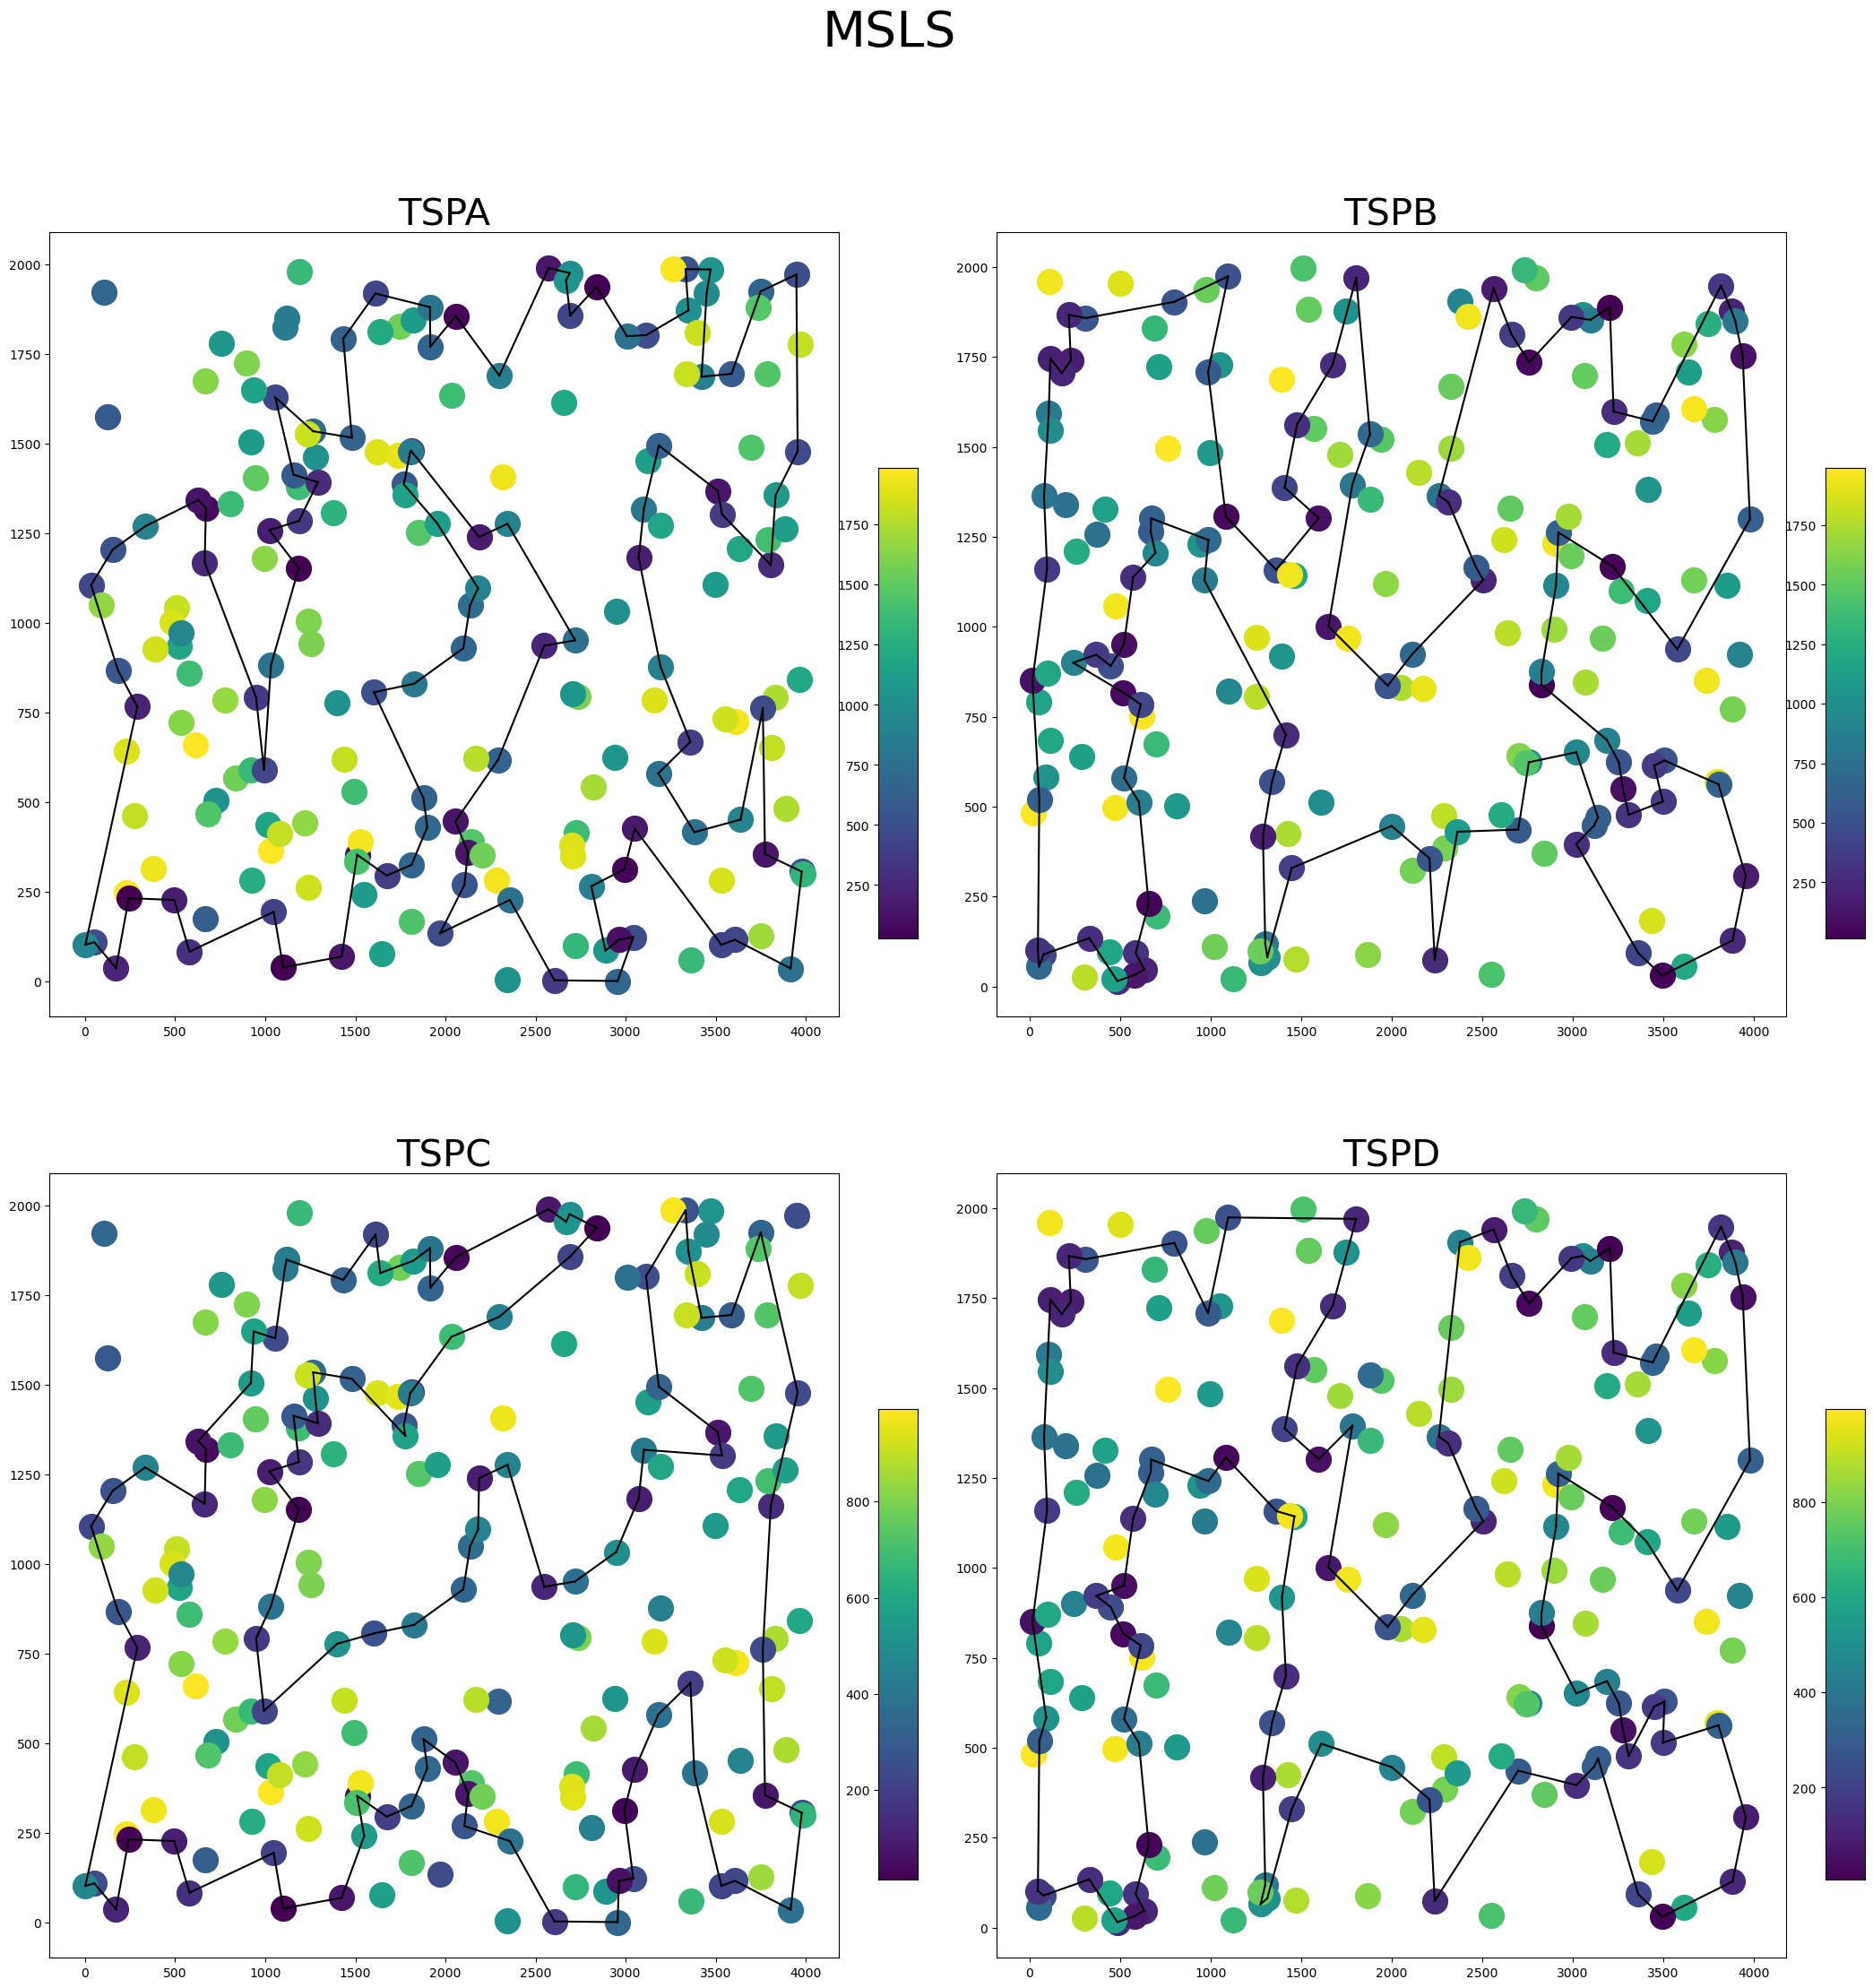

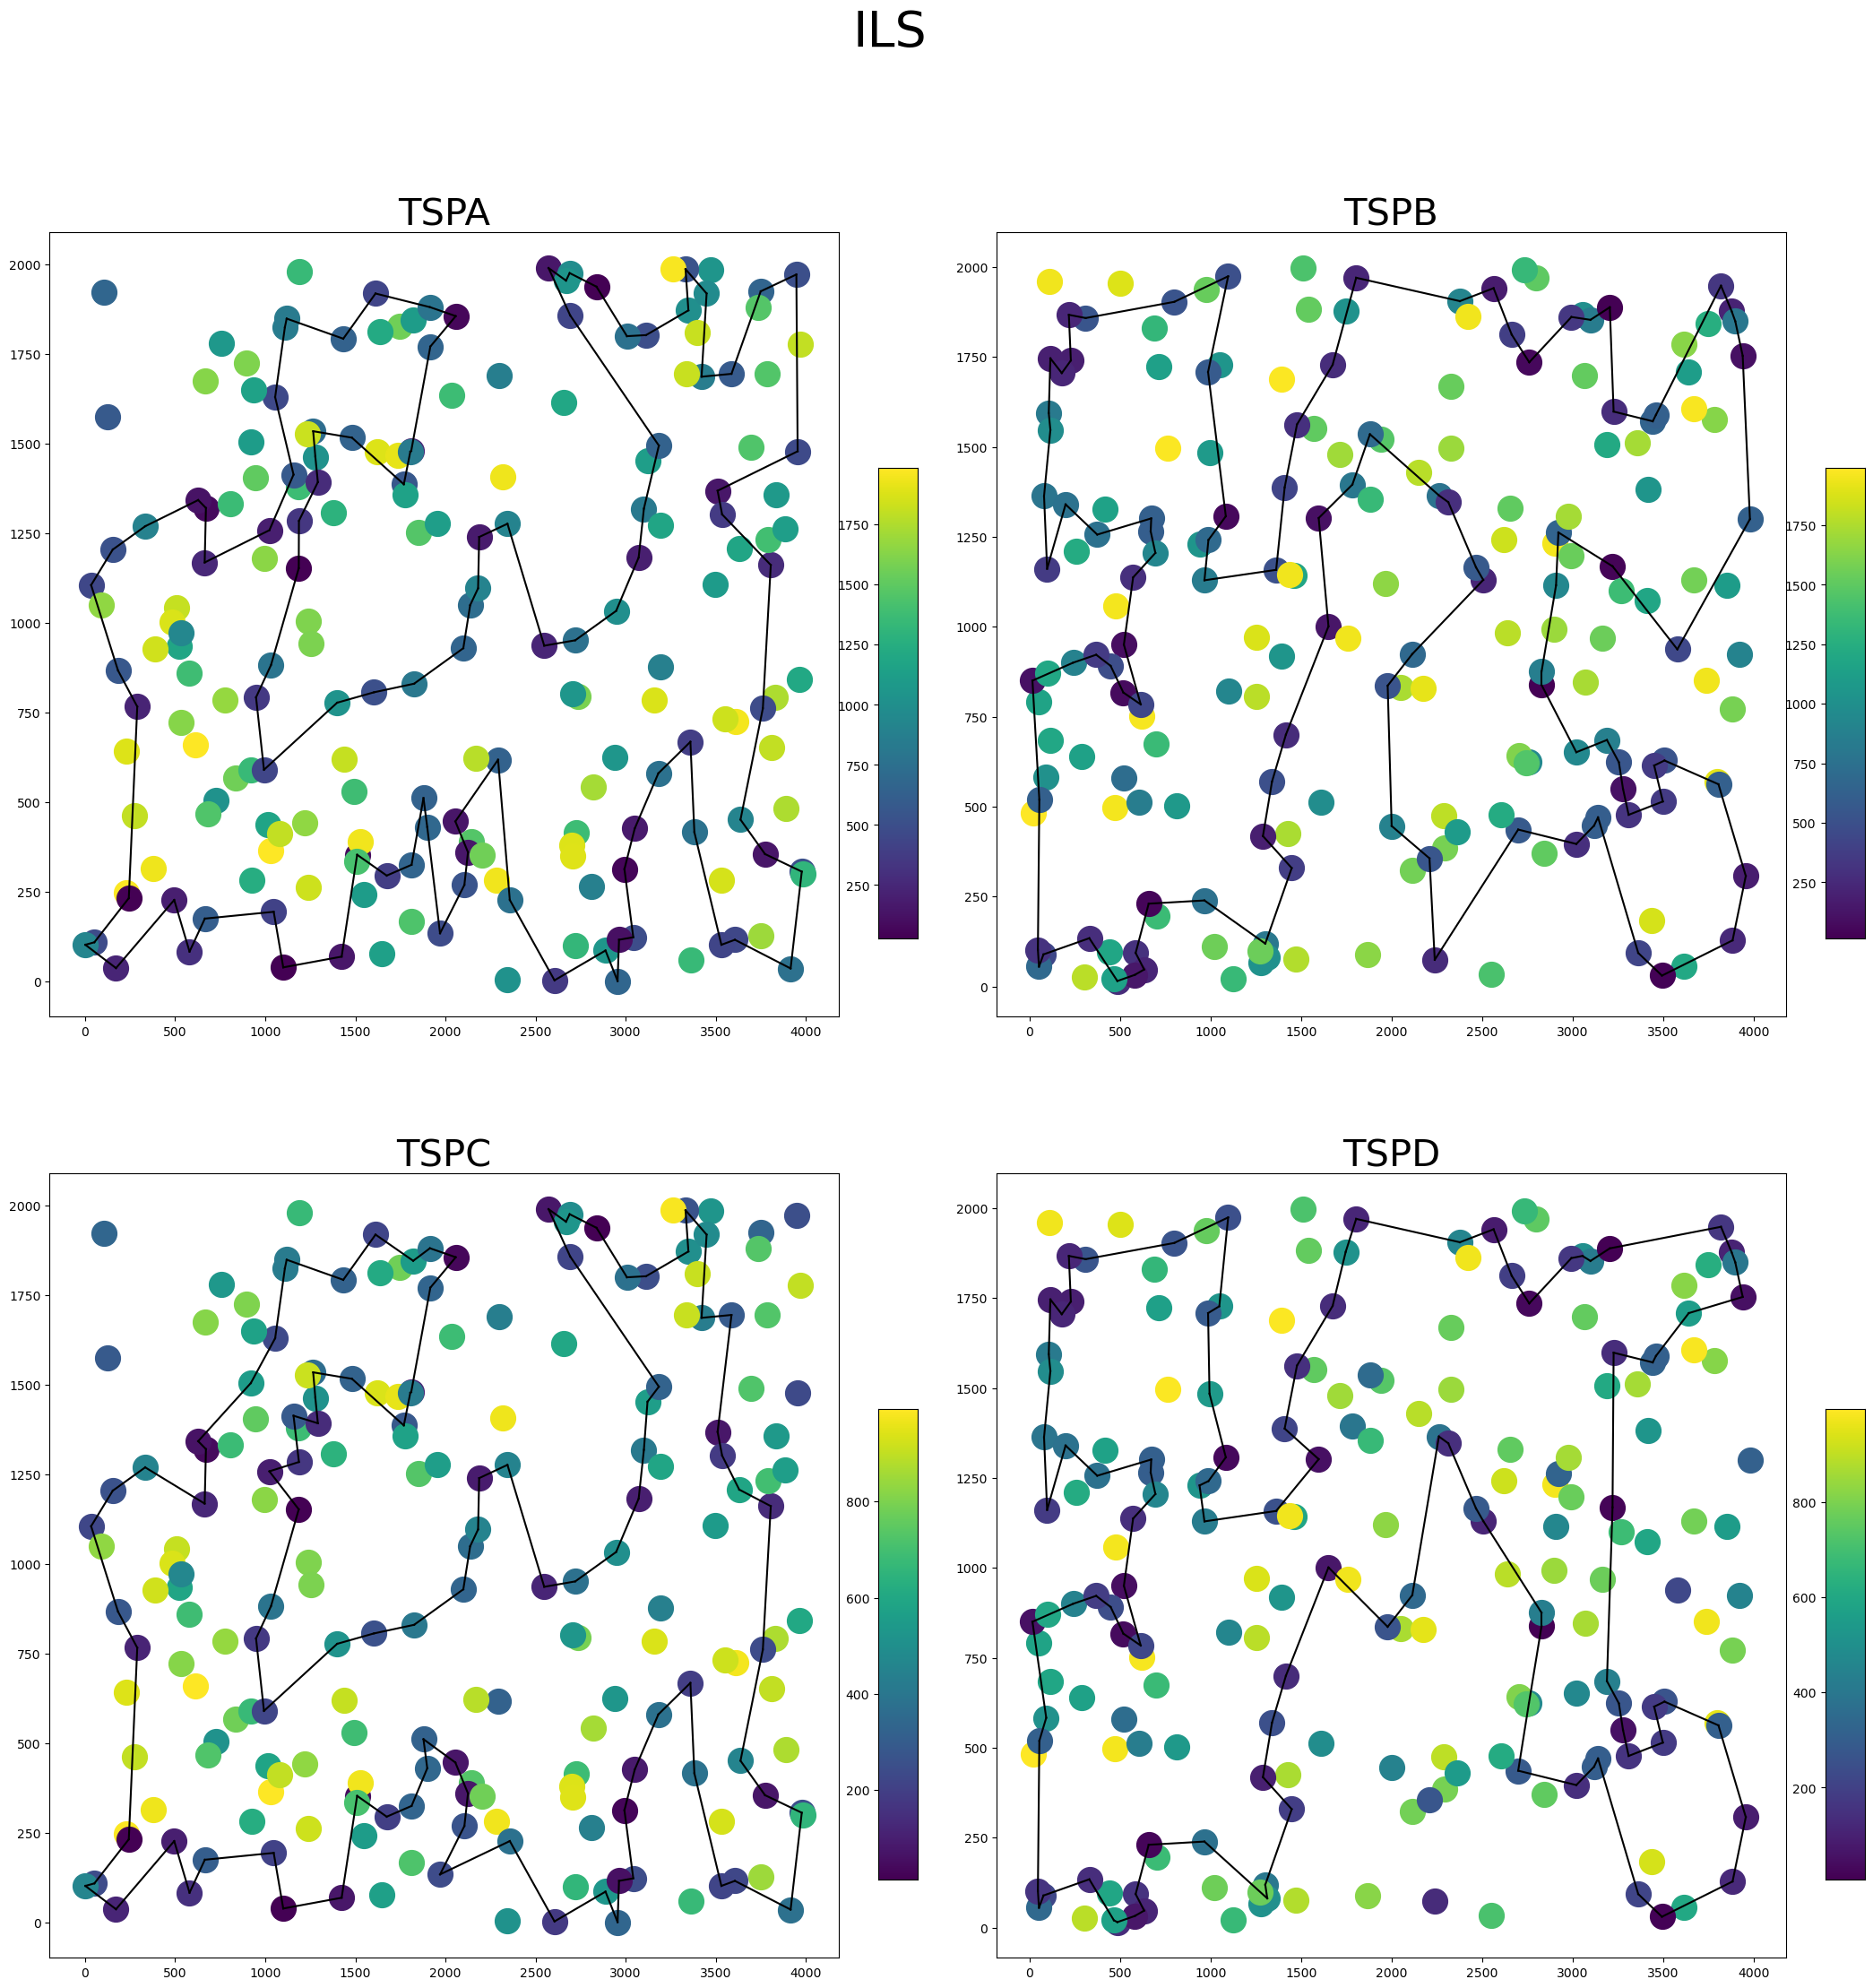

In [50]:
for algo in best_solutions:
    fig, ax = plt.subplots(2, 2, figsize=(25, 25))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(algo, fontsize=40)
    for instance in best_solutions[algo]:
        solution = best_solutions[algo][instance]
        df = pd.read_csv(instance, names=['x', 'y', 'cost'], sep=';')
        weights = df['cost']
        cmap = plt.cm.viridis
        norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
        ax[idx].set_title(instance.replace('../data/', '').replace('.csv', ''), fontsize=30)
        for i in range(len(df)):
            x, y, cost = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['cost']
            ax[idx].plot(x, y, "o", markersize=20, color=cmap(norm(cost)))
        for i in range(len(solution)-1):
            x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
            x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
            ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
        ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        
        axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)

        axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
        axins.xaxis.set_visible(False)
        
        idx += 1
        
    plt.savefig(f'./plots/{algo}.png', dpi=300)
    plt.show()